In [1]:
import numpy as np 
import pandas as pd
from PIL import Image

import os
import csv 

import sklearn as skl
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pre-processing - done by Baquar
def load_data(data_dir, labels_dir, labels_target_dir):
    # Load in data
    data = np.array([])
    img_names = np.array([])
    d_size = 0
    for filename in os.listdir(jaffe_dir):
        if filename.endswith(".tiff"):
            im = Image.open(os.path.join(jaffe_dir, filename))
            imarray = np.array(im)
            data = np.append(data, imarray)
            name = filename.replace('.tiff', '')
            img_names = np.append(img_names, name)
            d_size = d_size+1

    label_head = ['#', 'HAP', 'SAD', 'SUR', 'ANG', 'DIS', 'FEA', 'PIC']
    labels = pd.read_csv(
        labels_dir, 
        sep=' ', 
        header=None,
        names = label_head
        )
    # reshape data such that each row is a 256x256 image of a face
    data = np.reshape(data, (d_size, -1))

    return data, labels, img_names

def save_data(data, labels, img_names):
    # Save data to avoid future reading
    np.save('datasets/jaffe_loaded.npy', data)
    # Save labels to separate csv
    labels.to_csv(labels_target_dir, sep=',')
    # save img names to separate csv
    with open('datasets/jaffe_img_ids.txt', 'w') as F:
        wr = csv.writer(F)
        wr.writerow(img_names)

if __name__ == '__main__':

    jaffe_dir = 'datasets/jaffe/jaffedbase/'
    labels_dir = 'datasets/jaffe/labels.txt'
    labels_target_dir = 'datasets/jaffe_labels.csv'

    data, labels, img_names = load_data(
        jaffe_dir,
        labels_dir,
        labels_target_dir
    )

    save_data(data, labels, img_names)


def train_test_split(df):
    
    df.sample(frac=1)
    print('Data loaded and shuffled.')

    # n_neighbors = int(input("n_neighbors: "))
    n_obs = df.shape[0]
    train_frac = 0.7

    trainset = df.iloc[:int(train_frac*n_obs), :]
    testset = df.iloc[int(train_frac*n_obs):n_obs-1, :]

    train_labels = trainset.expression
    train_inputs = trainset.drop(columns=['expression', 'Unnamed: 0'], axis=1)

    test_labels = testset.expression
    test_inputs = testset.drop(columns=['expression', 'Unnamed: 0'], axis=1)

    print("\nTrain inputs shape: {0}, train labels shape: {1}".format(
        train_inputs.shape,
        train_labels.shape
    ))

    print("\nTest inputs shape: {0}, test labels shape: {1}".format(
        test_inputs.shape,
        test_labels.shape
    ))

    return train_inputs, train_labels, test_inputs, test_labels

In [3]:
#pre-processing - done by Baquar
def process_names(st):
    st = list(st)
    for i in range(len(st)):
        if st[-1] == '.':
            break
        else:
            st.pop()
    st.pop()
    st = ''.join(st)
    st = st.replace('.', '-')
    return st

################################################################

# Loading in saved data
data_dir = 'datasets/jaffe_loaded.npy'
names_dir = 'datasets/jaffe_img_ids.txt'
labels_dir = 'datasets/jaffe_labels.csv'

df = pd.DataFrame(data=np.load(data_dir))
names = pd.read_csv(names_dir, delimiter=',', header=None).to_numpy().squeeze()

# Manipulate image names to match label format
names = [process_names(name) for name in names]

# Add names column to image df
df['names'] = names

df_labels = pd.read_csv(labels_dir)
df_labels = df_labels.drop(columns='Unnamed: 0', axis=1)

'''
The labels are given as a table of 6 mean scores for each image.
Therefore, we take the expression with the highest mean score among these
six, and use that as the label for that image.
'''

df_labelids = df_labels.PIC
df_labels = df_labels.drop(columns=['PIC', '#'], axis=1)

expressions = []
for i, row in enumerate(df_labels.to_numpy()):
    # print(type(row))
    expression = np.argmax(row)
    expressions.append(expression)

df_labels['names'] = df_labelids
df_labels['expression'] = expressions

df_all = pd.merge(df, df_labels, on='names')

df_final = df_all.drop(
    columns=['names', 'HAP', 'SAD', 'SUR', 'ANG', 'DIS', 'FEA'],
    axis=1
)

df_final.to_csv(
    'datasets/final_data.csv',
    sep=','
)
#################################################################

In [4]:
X = df_final.iloc[:, 0:65536]
y = df_final.iloc[:, 65536]

X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y)

In [5]:
clf = SVC(kernel = 'poly', degree = 2, gamma = 'scale')

C = [1, 2, 3]
params = {'C': C}

grid_search = GridSearchCV(clf, params, return_train_score = True, iid = True, cv = KFold(3))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=2,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=None, param_grid={'C': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [6]:
def draw_heatmap(acc, acc_desc, c):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=c, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='C')
    plt.title(acc_desc + ' w.r.t C')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

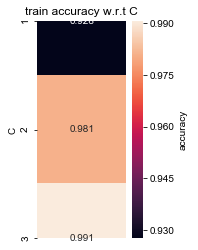

In [7]:
train_acc = grid_search.cv_results_['mean_train_score'].reshape(-1, 1)
draw_heatmap(train_acc, 'train accuracy', C)

In [8]:
score = grid_search.best_estimator_.score(X_test, y_test)
print(grid_search.best_params_)
print("Accuracy score: " + str(score))

{'C': 2}
Accuracy score: 0.6981132075471698
